<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/spline_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


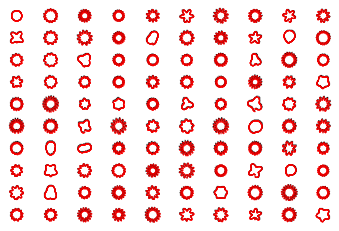

In [28]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print(x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,2*numpoints)
    for l in range(length):
        canvas[l,x[l,:].type(torch.LongTensor),y[l,:].type(torch.LongTensor)]=1.0
        #points[l,:,0] = x[l,:]
        #points[l,:,1] = y[l,:]
        points[l,:numpoints] = x[l,:]#modified for lstm discriminator
        points[l,-numpoints:] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[0,:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            print("sample", sample.shape)
            temp = sample.unsqueeze(0).cuda()
            temp = torch.cat([temp,temp]).cuda()
            pred = model(temp)
            pred = pred[0]
            print('pred', pred.shape)
            predres = (int)(pred.shape[0]/2)
            #print(pred.shape,predres, predres/2)
            X = pred[:predres]
            Y = pred[-predres:]
            #print('X',X.shape)
            #print(Y.shape)

            #print (X.shape,Y.shape)
            s = [.001 for x in range(predres)]
            #print('s',len(s))
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            #print('c',len(c))
            assert len(c) == predres
            ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)

        X = labels[:numpoints]
        Y = labels[-numpoints:]
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        canvas = torch.reshape(canvas,(1,side,side))
        assert canvas.shape == (1,side,side)
        
        #canvas = torch.from_numpy(canvas)
        #canvas = canvas.repeat(3, 1, 1).float()
        #print('canvashape',canvas.shape)
        #canvas = torch.cat([canvas,columns.unsqueeze(0),rows.unsqueeze(0)])
        assert canvas.shape == (1,side,side)
        points = self.values["points"]
        points = points[idx,:]

        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('donut.png',dataset, model = None)

In [2]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url



class MLPGEN(nn.Module):

    def __init__(self):
        super(MLPGEN, self).__init__()
        self.hidden_dim = 32*32
        self.featurevector = None
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, 2000),
            nn.Sigmoid()
        )
    

    def forward(self, x):
        #print(self.featurevector.shape)
        print(x.shape)
        first = x.shape[0]
        x = torch.flatten(x[:,0,:,:],start_dim=1)
        if x.shape != (first,self.hidden_dim):
            print('bad shape', x.shape)

        assert x.shape == (first,self.hidden_dim)
        return 32.0*self.mlp(x)

In [3]:
model = MLPGEN().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.5, 0.999), weight_decay=0.1)


In [4]:
def my_loss(output, target):
    loss = torch.mean(torch.abs(output - target))
    return loss


In [5]:
dataset_train = DonutDataset(4000)
dataset_val = DonutDataset(100)

torch.Size([4000, 1]) torch.Size([4000, 1]) torch.Size([4000, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

loader_train = data.DataLoader(
    dataset_train, batch_size=64,
    sampler=RandomSampler(data_source = dataset_train),
    num_workers=4)
loader_train = loader_train
model.train()
for i in range(10):
  for x,y in loader_train:
    x = x.cuda()
    y = y.cuda()
    generated_sequence = model(x)
    loss = my_loss(generated_sequence, y)
    loss.backward()
    print(loss)
    optimizer.step()
    

In [ ]:
DonutDataset.displayCanvas('training-set.png', dataset_train, model)
DonutDataset.displayCanvas('validation-set.png', dataset_val, model)

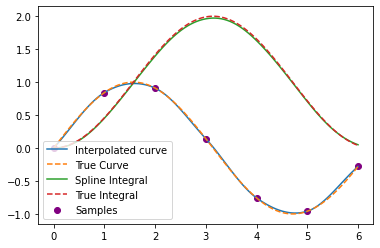

In [82]:
import matplotlib.pylab as P
import torch as T

def h_poly_helper(tt):
  A = T.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def H_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = t
  for i in range(1, 4):
    tt[i] = tt[i-1]*t*i/(i+1)
  return h_poly_helper(tt)

def interp(x, y, xs):
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  m = T.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  I = P.searchsorted(x[1:].cpu().detach().numpy(), xs.cpu().detach().numpy())
  I = T.from_numpy(I).cuda()
  dx = (x[I+1]-x[I])
  hh = h_poly((xs-x[I])/dx)
  
  return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx

def integ(x, y, xs):
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  m = T.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  I = P.searchsorted(x[1:], xs)
  Y = T.zeros_like(y)
  Y[1:] = (x[1:]-x[:-1])*(
      (y[:-1]+y[1:])/2 + (m[:-1] - m[1:])*(x[1:]-x[:-1])/12
      )
  Y = Y.cumsum(0)
  dx = (x[I+1]-x[I])
  hh = H_poly((xs-x[I])/dx)
  return Y[I] + dx*(
      hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
      )

# Example
if __name__ == "__main__":
  x = T.linspace(0, 6, 7)
  y = x.sin()
  xs = T.linspace(0, 6, 101)
  ys = interp(x, y, xs)
  Ys = integ(x, y, xs)
  P.scatter(x, y, label='Samples', color='purple')
  P.plot(xs, ys, label='Interpolated curve')
  P.plot(xs, xs.sin(), '--', label='True Curve')
  P.plot(xs, Ys, label='Spline Integral')
  P.plot(xs, 1-xs.cos(), '--', label='True Integral')
  P.legend()
  P.show()


1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


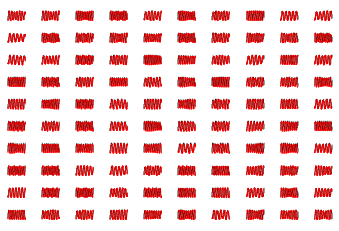

In [83]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)

for i in range(32):
    columns[:,i] = i
    rows[i,:] = i

def sinusoid(length = 10):
    
    canvas = torch.zeros((length,side, side))
    dx = (31.0-1.0)/numpoints
    x0 = 1.0
    xx = torch.zeros(length,numpoints)
    yy = torch.zeros(length,numpoints)
    for j in range(length):
      x = torch.tensor([x0+dx*i for i in range(1000)])
      y = torch.zeros_like(x)
      y = 7.0*torch.sin(x*(torch.rand(1).item()+1.0))+torch.cos(x*(torch.rand(1).item()+1.0))+16.0
      xx[j] = x
      yy[j] = y
    
    x = xx
    y = yy
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,2*numpoints)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        #points[l,:,0] = x[l,:]
        #points[l,:,1] = y[l,:]
        points[l,:numpoints] = x[l,:]#modified for lstm discriminator
        points[l,-numpoints:] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[0,:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            print("sample", sample.shape)
            temp = sample.unsqueeze(0).cuda()
            temp = torch.cat([temp,temp]).cuda()
            pred = model(temp)
            pred = pred[0]
            print('pred', pred.shape)
            predres = (int)(pred.shape[0]/2)
            #print(pred.shape,predres, predres/2)
            X = pred[:predres]
            Y = pred[-predres:]
            #print('X',X.shape)
            #print(Y.shape)

            #print (X.shape,Y.shape)
            s = [.001 for x in range(predres)]
            print('s',len(s))
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            print('c',len(c))
            assert len(c) == predres
            ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        X = labels[:numpoints]
        Y = labels[-numpoints:]
        s = [.001 for x in range(numpoints)]
        print(len(s))
        c = ['red' for x in range(numpoints)]
        print(len(c))
        ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class SinCosDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = sinusoid(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        canvas = torch.reshape(canvas,(1,side,side))
        assert canvas.shape == (1,side,side)
        
        #canvas = torch.from_numpy(canvas)
        #canvas = canvas.repeat(3, 1, 1).float()
        #print('canvashape',canvas.shape)
        #canvas = torch.cat([canvas,columns.unsqueeze(0),rows.unsqueeze(0)])
        assert canvas.shape == (1,side,side)
        points = self.values["points"]
        points = points[idx,:]

        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = SinCosDataset(length = 100)
SinCosDataset.displayCanvas('sincos.png',dataset, model = None)

In [84]:
torch.rand(1).item()

0.4015662670135498

In [45]:
dataset[0][1]

tensor([ 1.0000,  1.0300,  1.0600,  ..., 21.0759, 20.8558, 20.6286])

In [46]:
dataset_train = SinCosDataset(4000)
dataset_val = SinCosDataset(100)

In [47]:
model = MLPGEN().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005, betas=(0.5, 0.999), weight_decay=0.1)

In [79]:
oc = 1000
x = T.linspace(0, 32, 25).cuda()
xs = T.linspace(0, 32, 1000).cuda()
xoc = T.linspace(0, 32, oc).cuda()
print(xoc.shape)

torch.Size([1000])


In [86]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

loader_train = data.DataLoader(
    dataset_train, batch_size=64,
    sampler=RandomSampler(data_source = dataset_train),
    num_workers=4)
loader_train = loader_train
model.train()
model = model.cuda()
for i in range(60):
  for x,y in loader_train:
    x = x.cuda()
    y = y.cuda()
    output = model(x)
    output = output
    #print('xoc',xoc.shape)
    #print('output', output.shape)
    print('y.shape', y.shape)
    #print(y[0][0], y[0][-1])
    print(xs.device.type)
    inte = [interp(output[i,-1000:],output[i,:1000],xs) for i in range(64)]
    inte = T.cat(inte)
    inte = inte.reshape(64,-1)
    print('inte',inte.shape)
    yout = inte
    loss = T.mean((yout-yin.detach())**2)
    
    loss.backward()
    print(loss)
    optimizer.step()
    

torch.Size([64, 1, 32, 32])
y.shape torch.Size([64, 2000])
cpu


RuntimeError: ignored

In [ ]:
#SinCosDataset.displayCanvas('training-set.png', dataset_train, model)
SinCosDataset.displayCanvas('validation-set.png', dataset_val, model)

In [ ]:
for i in range(1000):
  c = [T.linspace(0, 32, 1000) for x in range(16)]
  xin = T.cat(c).reshape(16,-1)
  output = model(modelin).squeeze()
  
  inte = [interp(xoc,output[i,:],xs) for i in range(16)]
  inte = T.cat(inte)
  inte = inte.reshape(16,-1)
  yout = inte
  loss = T.mean((yout-yin.detach())**2)
  print('loss',loss)
  loss.backward()
  optimizer.step()
